In [ ]:
import iris.utils.data_utils as data_utils
from iris.config.localization_pipeline_config_manager import LocalizationPipelineConfigManager
from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.data_pipeline.mongodb_manager import MongoDBManager

# YOLOS imports
from transformers import AutoProcessor, YolosForObjectDetection
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import List, Dict, Any

In [ ]:
# Initialize configurations
localization_config = LocalizationPipelineConfigManager()
data_config = DataPipelineConfigManager()
shop_config = data_config.shop_configs["nikolaj_storm"]
mongodb_config = data_config.mongodb_config

# Create MongoDB manager
mongodb_manager = MongoDBManager(shop_config, mongodb_config)

# Initialize YOLOS model and processor
print("Loading YOLOS model...")
model = YolosForObjectDetection.from_pretrained("valentinafeve/yolos-fashionpedia")
processor = AutoProcessor.from_pretrained("valentinafeve/yolos-fashionpedia")
print("Model loaded!")

Loading YOLOS model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Model loaded!


In [4]:
def detect_fashion_items(image_hash: str, confidence_threshold: float = 0.3):
    # Get image data from MongoDB
    image_data = mongodb_manager.get_collection(
        mongodb_manager.mongodb_config.image_metadata_collection
    ).find_one({"image_hash": image_hash})
    
    if image_data is None:
        raise ValueError(f"No image found with hash: {image_hash}")
    
    # Load image
    image = Image.open(image_data['local_path'])
    
    # Preprocess and run inference
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    
    # Postprocess results
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=confidence_threshold, target_sizes=target_sizes)[0]
    
    # Convert detections to list format
    detections = []
    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        score_val = score.item()
        label_text = model.config.id2label[label.item()]
        box_coords = box.tolist()
        
        detections.append({
            'label': label_text,
            'score': score_val,
            'box': box_coords
        })
    
    # Sort by confidence score
    detections.sort(key=lambda x: x['score'], reverse=True)
    
    # Store results in MongoDB
    detection_results = {
        'image_hash': image_hash,
        'detections': detections
    }
    
    # Update or insert results in MongoDB
    mongodb_manager.get_collection('fashion_detections').update_one(
        {'image_hash': image_hash},
        {'$set': detection_results},
        upsert=True
    )
    
    # Display results
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    ax = plt.gca()
    
    for detection in detections:
        box = detection['box']
        score_val = detection['score']
        label_text = detection['label']
        
        # Draw bounding box
        rect = patches.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1],
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        plt.text(
            box[0], box[1]-5,
            f"{label_text}: {score_val:.2f}",
            color='white',
            bbox=dict(facecolor='red', alpha=0.8),
            fontsize=8
        )
    plt.title("Fashion Detections")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print detection results
    print("\nDetected items:")
    print("-" * 50)
    for detection in detections:
        print(f"{detection['label']}: {detection['score']:.2f}")
    
    return detections

## Test Detection on Sample Images

Now let's test the detection on some sample images from MongoDB

Original image information:



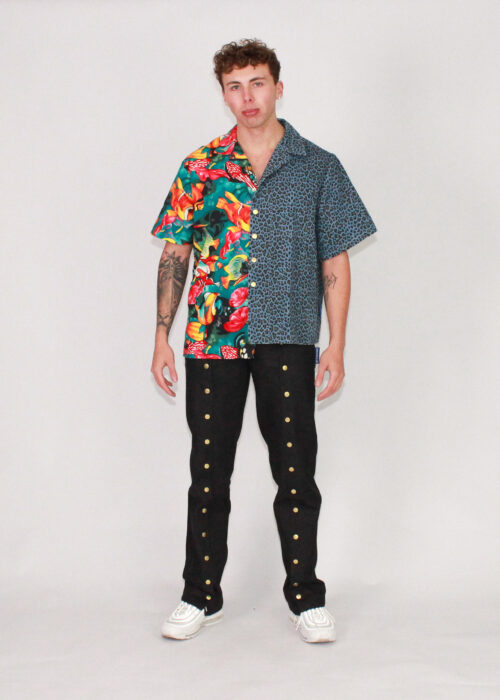
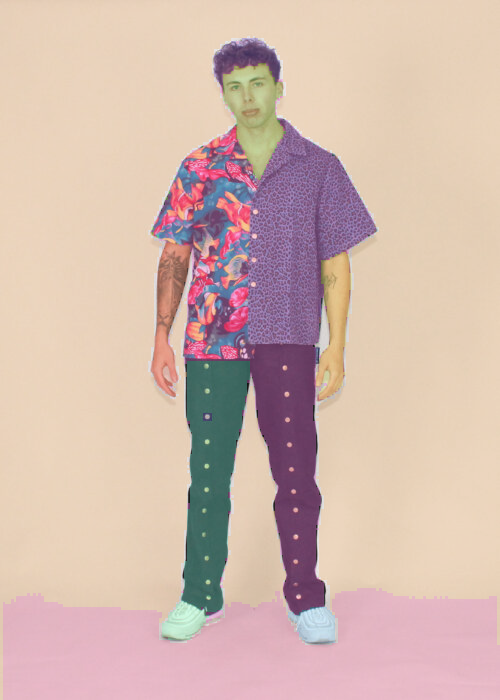
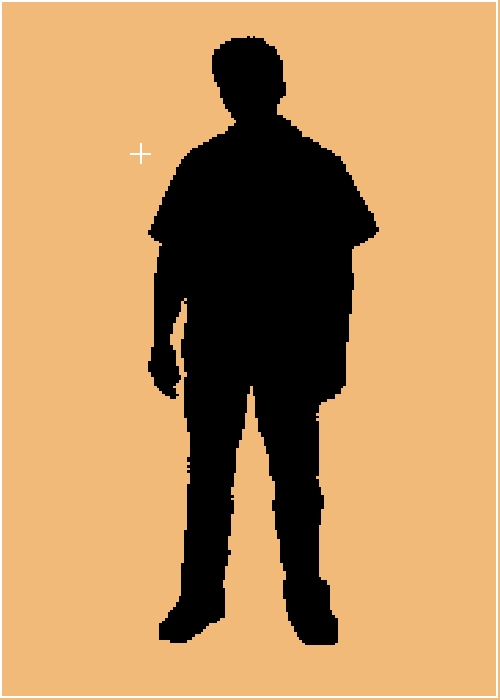
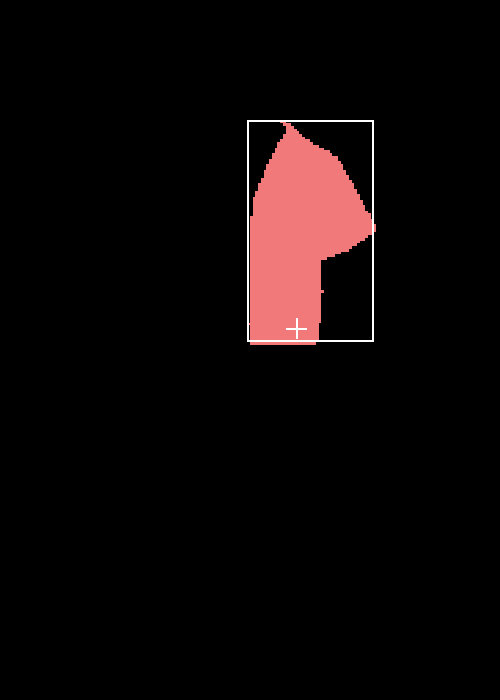
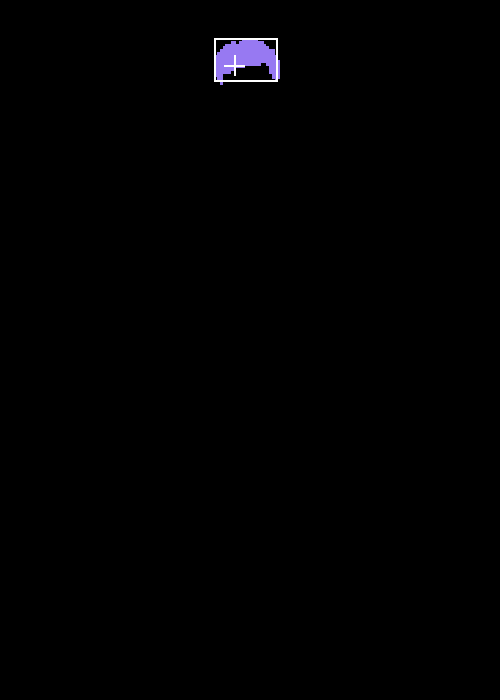
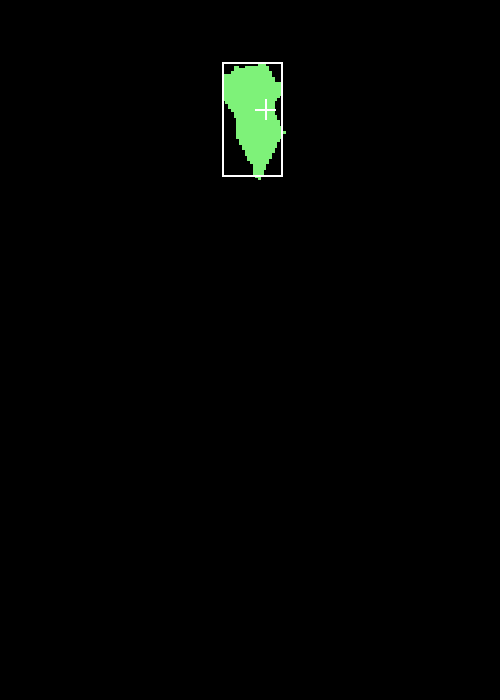
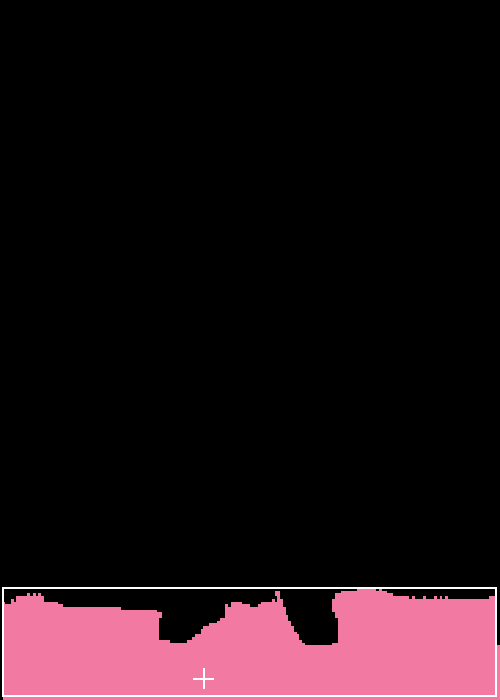
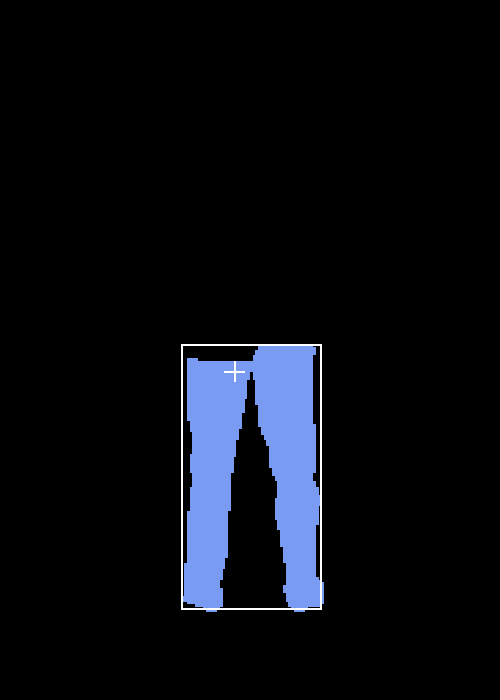
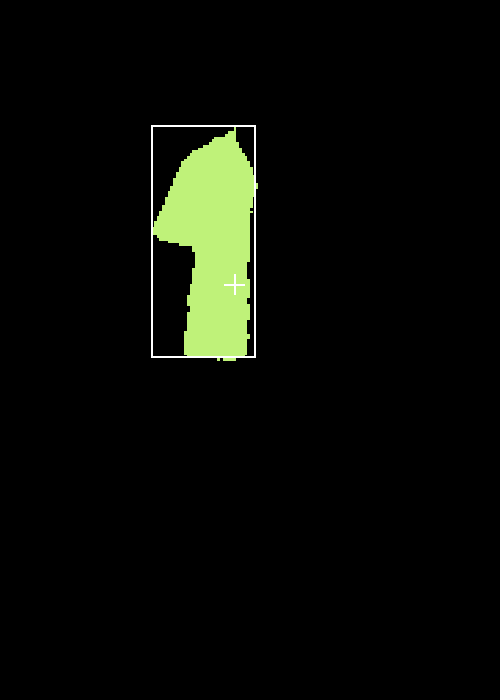
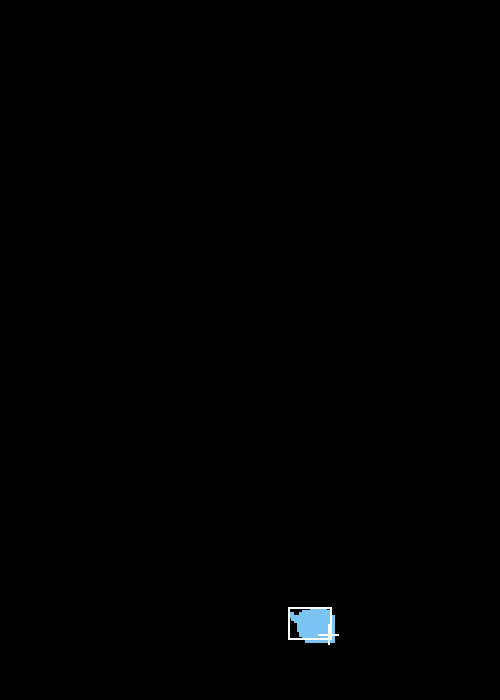
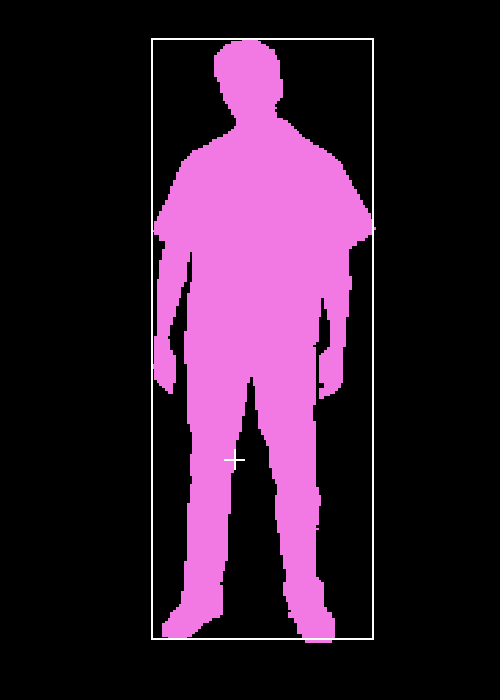
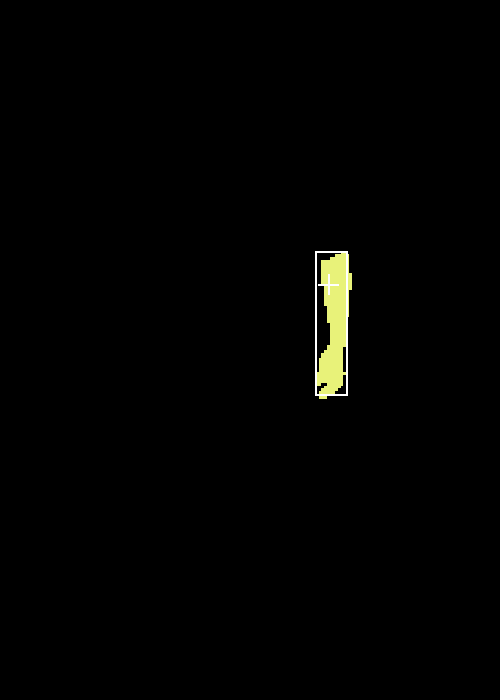
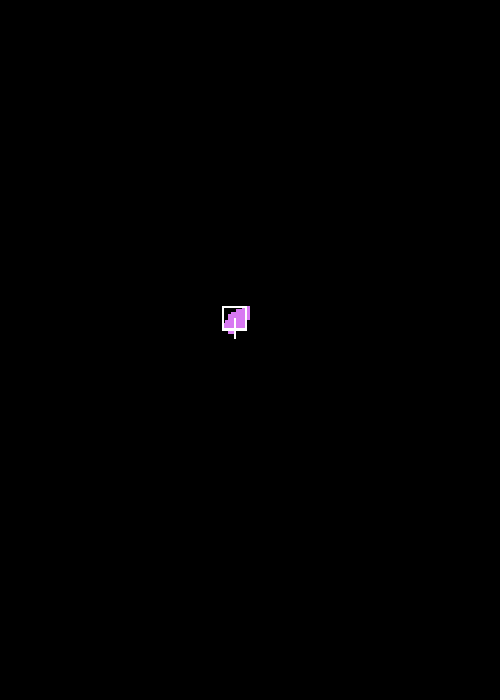
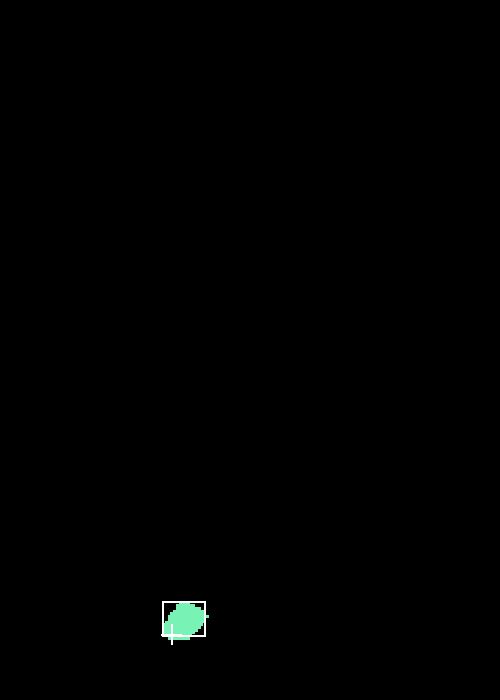
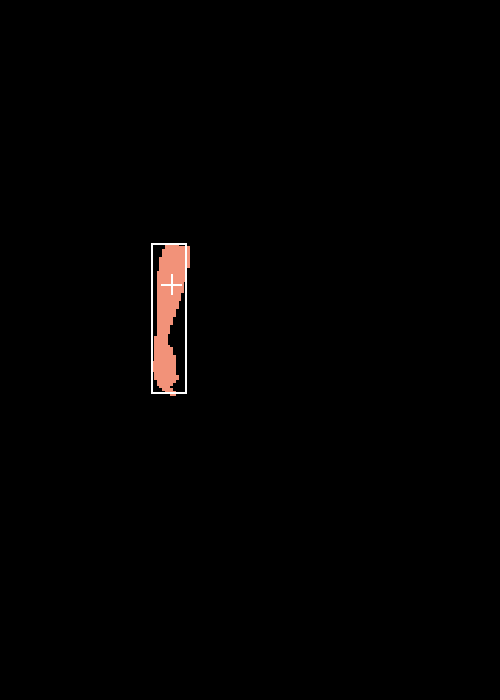
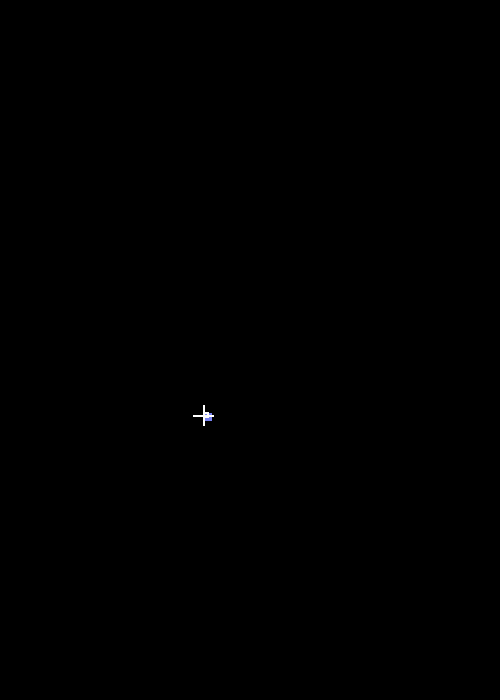
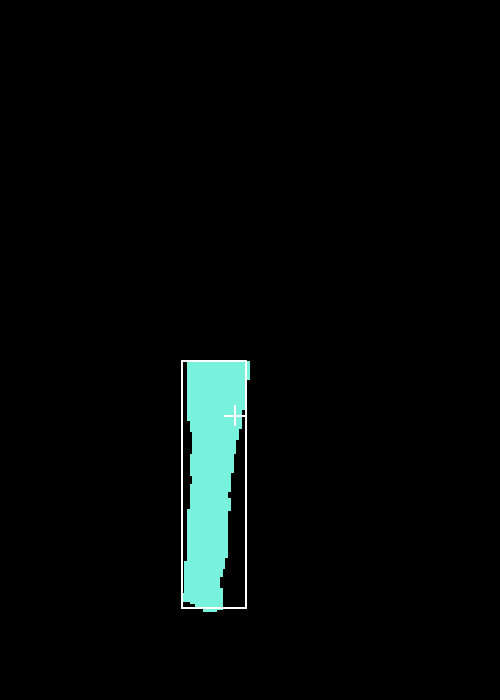


Running YOLOS detection...


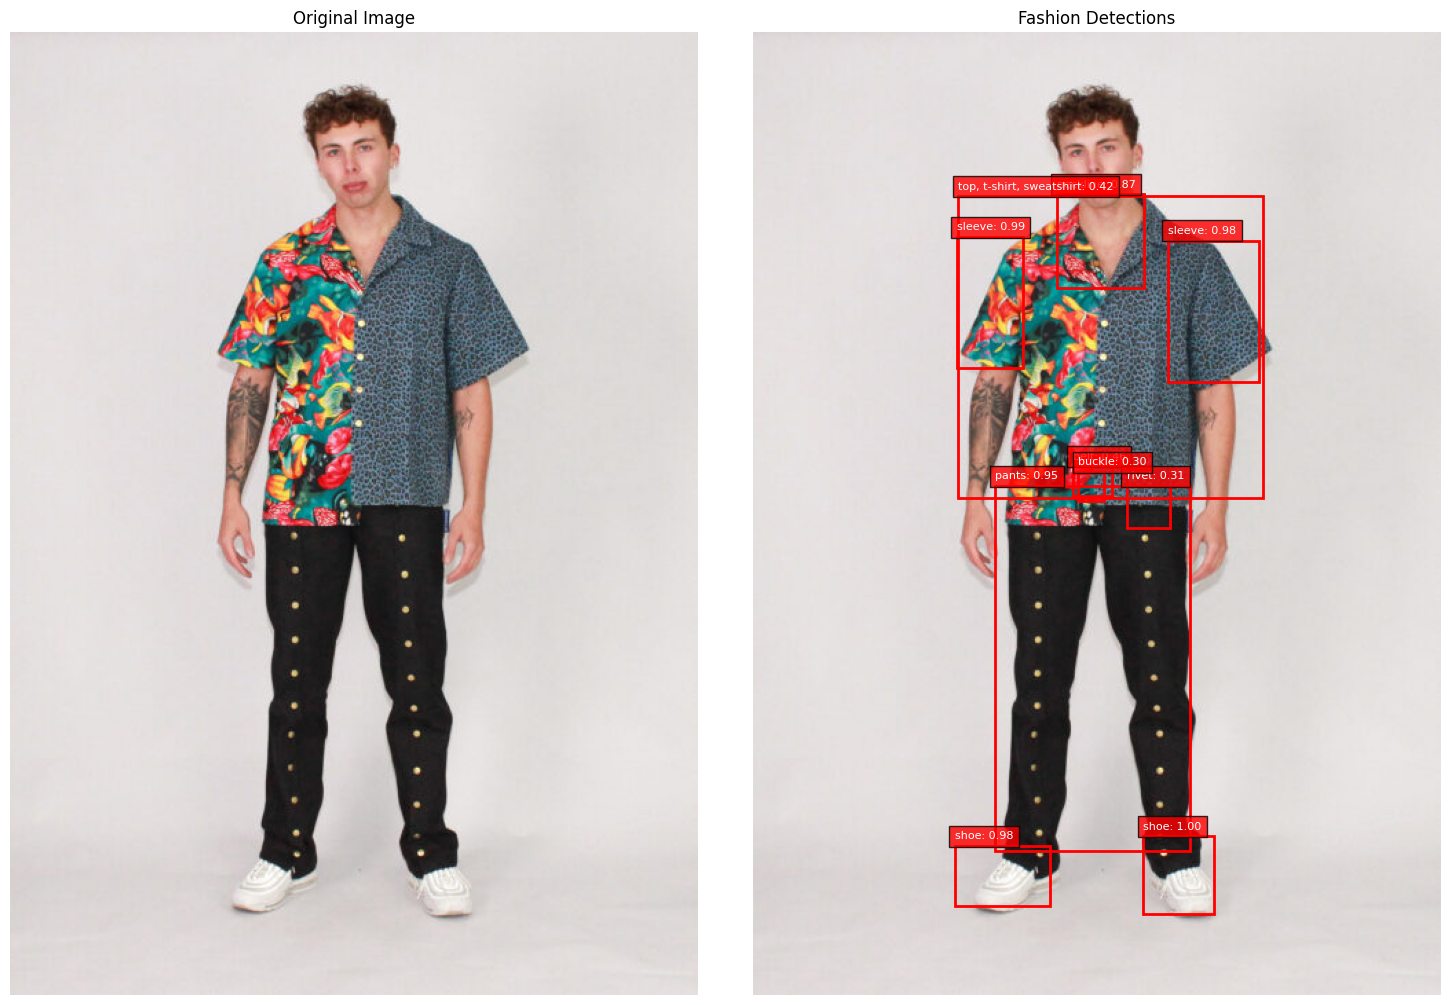


Detected items:
--------------------------------------------------
shoe: 1.00
sleeve: 0.99
shoe: 0.98
sleeve: 0.98
pants: 0.95
neckline: 0.87
belt: 0.46
top, t-shirt, sweatshirt: 0.42
rivet: 0.31
buckle: 0.30


In [5]:
# Test image
test_image_hash = 'df9e5f861a17b8fc4b9eec8c41a1fd11'

# Display original image info first
print("Original image information:")
data_utils.display_image_summary(mongodb_manager, test_image_hash, show_masks=True)

print("\nRunning YOLOS detection...")
detections = detect_fashion_items(test_image_hash, confidence_threshold=0.3)